# Finite Element Analysis [ME335A]

### Computing Project 1

In [1]:
# Simple FEA program for ME335-Finite Element Analysis
# Authors: Gustavo Buscaglia and Adrian Lew
# Python version by Arijit Majumdar
# Blanks filled in by Myung Chul Kim
# nel:      number of elements
# nod:      number of vertices in the mesh (nodes in this case)
# X:        coordinates of vertices
# npe:      number of degrees of freedom per element
# dd:       number of spatial dimensions
# L:        length of the interval
# nunk:     number of unknowns/dimension of Wh ('m' in the notes)
# kk:       number of shape functions in an element (all elements the same)
# LG:       local-to-global map
# Etag:     constrained index set
# GG:       values of constrained components of uh
# hh:       values of natural boundary condition (one per node, non-zero only when needed)
# ff:       values of the right hand side in an element (constant)
# lamda:    reaction coefficient of the equation in an element (constant)
# K:        stiffness matrix
# F:        load vector
# lge:      local-to-global map for an element
# xe:       coordinate of the vertices of an element
# fe:       value of ff in an element
# lambdae:  value of lamda in an element
# hhe:      value of the natural boundary condition for each node of the element
# Ke:       element stiffness matrix
# Fe:       element load vector

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.size'] = 16

In [3]:
# Element matrix and load vector
def elementKandF(xe, fe, lambdae, hhe):
  h = xe[1] - xe[0] # Element size
  Ke = np.zeros((2,2))
  Fe = np.zeros(2)

  Ke[0, 0] = Ke[1, 1] = +1 / h + lambdae * h / 3
  Ke[0, 1] = Ke[1, 0] = -1 / h + lambdae * h / 6
  Fe = hhe + fe * h / 2 * np.ones(2)

  return Ke, Fe

In [4]:
# Basis functions (only for plotting)
def P1(x):
  N1 = 1 - x
  N2 = x
  dN1 = -1
  dN2 = +1

  return N1, N2, dN1, dN2

In [5]:
# Build a mesh - Elements are implicitly defined by two consecutive vertices
nel=100
nod=nel+1
X = np.linspace(0,1,nod,endpoint=True)

In [6]:
# Useful constants
npe=2
dd=1
L=1

In [7]:
# Build a local-to-global map
nunk=nod
kk=2
LG = np.zeros((kk,nel),dtype=int)

for i in range(nel):
  LG[0, i] = i + 1
  LG[1, i] = i + 2

In [8]:
# Finite element solver begins

In [9]:
# Parameters of the problem
EtaG=np.array([nel])
GG=np.array([1])
hh=np.zeros(nod);
hh[0]=-1;
ff=-2*np.ones(nel);
lamda=0;

In [10]:
# Assembly from local to global
K = np.zeros((nunk,nunk))
F = np.zeros((nunk,1))

In [11]:
# Assembly of active indices
for iel in range(nel):
  # setting the local data
  lge = LG[:,iel]
  xe = X[iel:iel+2];
  fe = ff[iel]
  hhe = hh[iel:iel+2]

  # computing element K and F
  Ke, Fe = elementKandF(xe,fe,lamda,hhe)

  # assigning elements
  K[lge[0]-1:lge[1], lge[0]-1:lge[1]] += Ke
  F[lge[0]-1:lge[1], 0] += Fe

In [12]:
# Assembly of constrained indices
K[-1, :] = 0; K[-1, -1] = 1.0
F[-1, 0] = GG[0]

In [13]:
# Solve
U = np.matmul(np.linalg.inv(K),F)

In [14]:
# Plotting (mesh specific)

In [15]:
# Plotting points (uniform spacing dx)
dx = L/1000
xp = np.arange(0,L+dx,dx)
nxp = len(xp)
up = np.zeros(nxp)
dup = np.zeros(nxp)

for kp in range(nxp):
  xx = xp[kp]
  nle = np.amax(np.where(X <= xx)[0])
  if xx == L:
    nle = nod - 2

  nri = nle + 1

  xl= (xx-X[nle])/(X[nri]-X[nle])
  N1, N2, dN1, dN2 = P1(xl)

  # Please pay attention to how the values of up and dup are computed
  up[kp] = U[nle, 0]*N1 + U[nle+1, 0]*N2
  dup[kp] = (U[nle, 0]*dN1+U[nle+1, 0]*dN2)/(X[nri]-X[nle])

In [16]:
# Exact solution
uep = np.zeros(nxp)
duep = np.zeros(nxp)
for kp in range(nxp):
    if lamda > 0:
        # Case 1: lambda > 0
        sqrt_lambda = np.sqrt(lamda)
        A = (lamda + sqrt_lambda * np.exp(-sqrt_lambda) + 2) / (lamda * (np.exp(sqrt_lambda) + np.exp(-sqrt_lambda)))
        B = (lamda - sqrt_lambda * np.exp(sqrt_lambda) + 2) / (lamda * (np.exp(sqrt_lambda) + np.exp(-sqrt_lambda)))
        C = -2 / lamda

        uep[kp] = A * np.exp(sqrt_lambda * xp[kp]) + B * np.exp(-sqrt_lambda * xp[kp]) + C
        duep[kp] = A * sqrt_lambda * np.exp(sqrt_lambda * xp[kp]) - B * sqrt_lambda * np.exp(-sqrt_lambda * xp[kp])

    elif lamda == 0:
        # Case 2: lambda = 0
        uep[kp] = xp[kp]**2 + xp[kp] - 1
        duep[kp] = 2 * xp[kp] + 1

    else:
        # Case 3: lambda < 0
        sqrt_neg_lambda = np.sqrt(-lamda)
        A = 1 / sqrt_neg_lambda
        B = (lamda + sqrt_neg_lambda * np.sin(sqrt_neg_lambda) + 2) / (lamda * np.cos(sqrt_neg_lambda))
        C = -2 / lamda

        uep[kp] = A * np.sin(sqrt_neg_lambda * xp[kp]) + B * np.cos(sqrt_neg_lambda * xp[kp]) + C
        duep[kp] = A * sqrt_neg_lambda * np.cos(sqrt_neg_lambda * xp[kp]) - B * sqrt_neg_lambda * np.sin(sqrt_neg_lambda * xp[kp])

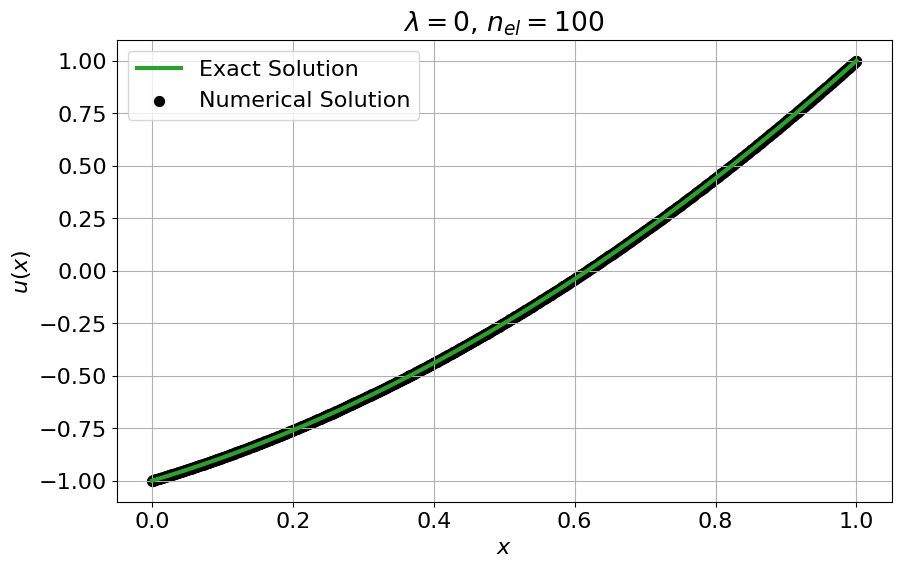

In [17]:
# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(xp, uep, linewidth=3, color='#2ca02c', label='Exact Solution')
plt.scatter(xp, up, s=50, color='black', label='Numerical Solution')
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x)$')
plt.legend()
plt.grid()
plt.title(rf'$\lambda={lamda}$, $n_{{el}}={nel}$')
plt.show()

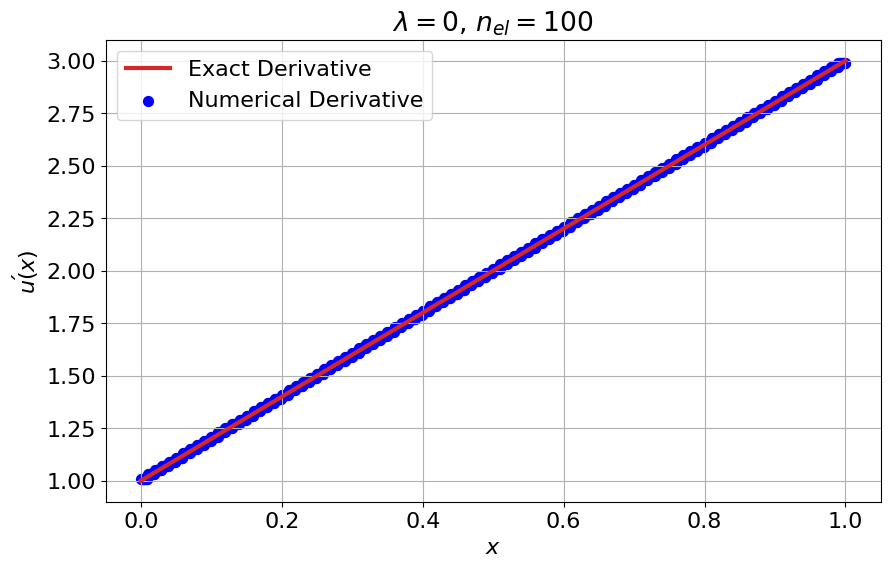

In [18]:
# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(xp, duep, linewidth=3, color='#d62728', label='Exact Derivative')
plt.scatter(xp, dup, s=50, color='blue', label='Numerical Derivative')
plt.xlabel(r'$x$')
plt.ylabel(r'$u\'(x)$')
plt.legend()
plt.grid()
plt.title(rf'$\lambda={lamda}$, $n_{{el}}={nel}$')
plt.show()

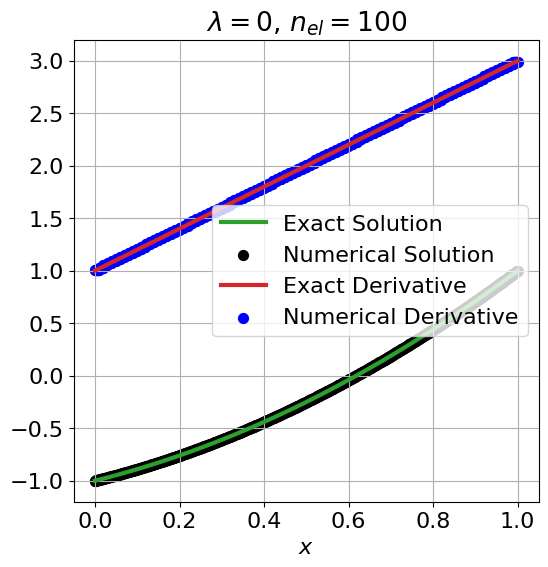

In [19]:
# Plot comparison
plt.figure(figsize=(6, 6))
plt.plot(xp, uep, linewidth=3, color='#2ca02c', label='Exact Solution')
plt.scatter(xp, up, s=50, color='black', label='Numerical Solution')
plt.xlabel(r'$x$')
# plt.ylabel(r'Function Value')
plt.plot(xp, duep, linewidth=3, color='#d62728', label='Exact Derivative')
plt.scatter(xp, dup, s=50, color='blue', label='Numerical Derivative')
plt.legend()
plt.grid()
plt.title(rf'$\lambda={lamda}$, $n_{{el}}={nel}$')
plt.show()

In [20]:
# Error analysis
error = np.linalg.norm(uep - up)
derror = np.linalg.norm(duep - dup)
print(f"Error in function: {error:.2e}")
print(f"Error in derivative: {derror:.2e}")

Error in function: 5.77e-04
Error in derivative: 1.85e-01



For λ = -10:


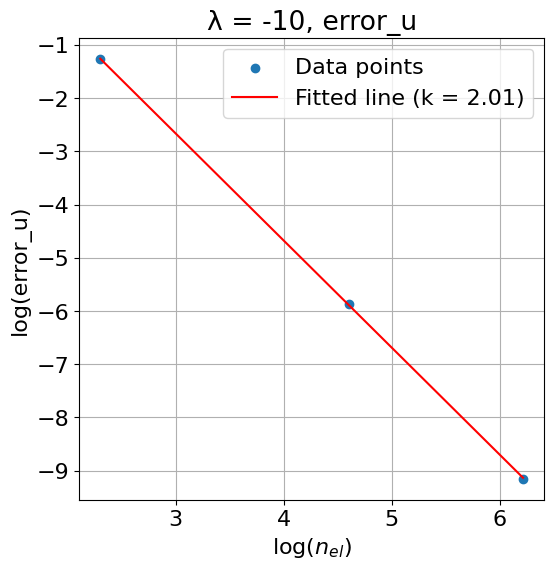

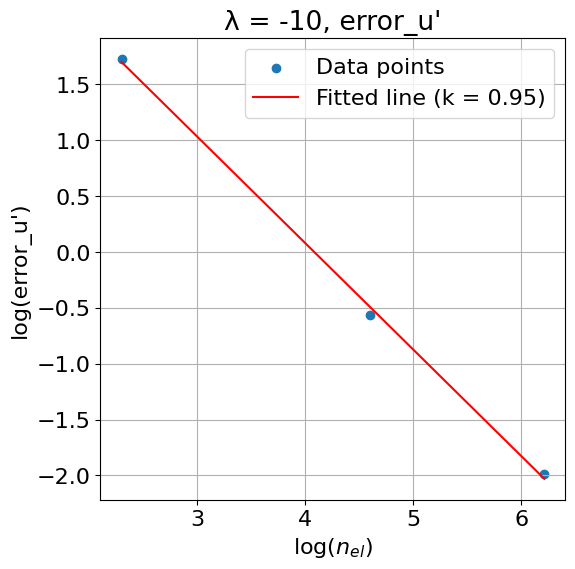

k for error_u: 2.01
k for error_u': 0.95

For λ = 10:


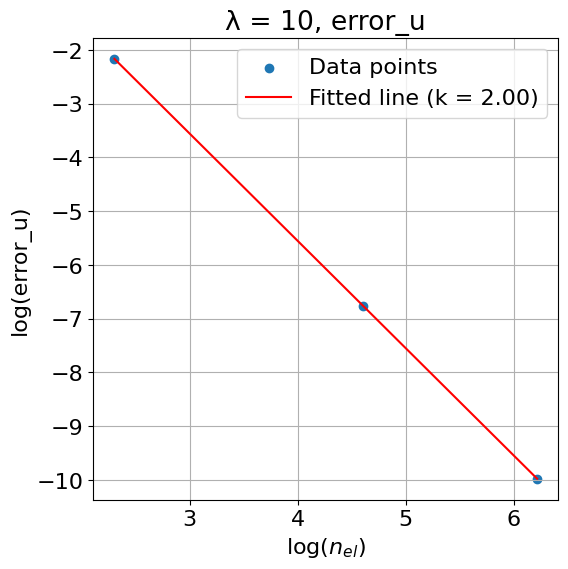

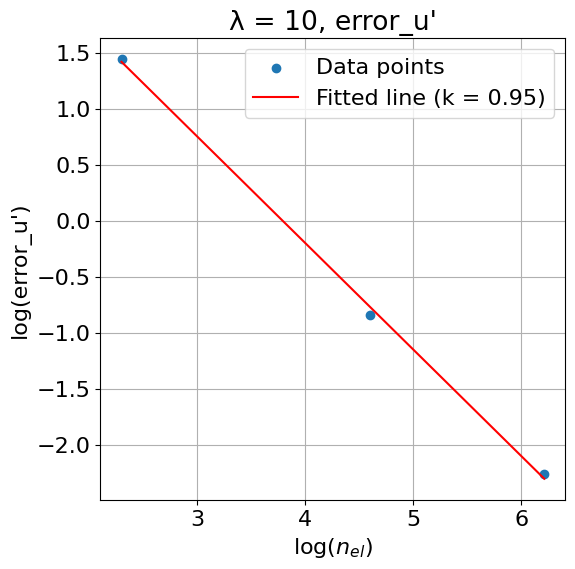

k for error_u: 2.00
k for error_u': 0.95


In [21]:
# Error fitting
# Data
lambdas = [-10, 10]
nel_values = [10, 100, 500]
error_u = {
    -10: [2.80e-01, 2.84e-03, 1.06e-04],
    # 0: [5.77e-2, 5.77e-4, 2.24e-5],
    10: [1.15e-01, 1.15e-03, 4.66e-05]
}
error_u_prime = {
    -10: [5.64, 5.67e-01, 1.37e-01],
    # 0: [1.83, 1.85e-1, 4.48e-2],
    10: [4.24, 4.31e-01, 1.04e-01]
}

# Calculate log values
log_nel = np.log(nel_values)

# Function to calculate k and plot
def calculate_k_and_plot(errors, error_type, lambda_val):
    log_error = np.log(errors)

    # Use polyfit to get the slope (and thus k)
    slope, intercept = np.polyfit(log_nel, log_error, 1)
    k = -slope

    plt.figure(figsize=(6, 6))
    plt.scatter(log_nel, log_error, label='Data points')
    plt.plot(log_nel, slope * log_nel + intercept, 'r', label=f'Fitted line (k = {k:.2f})')
    plt.xlabel(r'$\log(n_{el})$')
    plt.ylabel(f'log({error_type})')
    plt.title(f'λ = {lambda_val}, {error_type}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return k

# Process data and create plots
for lambda_val in lambdas:
    print(f"\nFor λ = {lambda_val}:")
    k_u = calculate_k_and_plot(error_u[lambda_val], 'error_u', lambda_val)
    k_u_prime = calculate_k_and_plot(error_u_prime[lambda_val], "error_u'", lambda_val)
    print(f"k for error_u: {k_u:.2f}")
    print(f"k for error_u': {k_u_prime:.2f}")